# Hedging in Slate Recommendation

In this notebook, we're going to move on from the classical _single_ recommendation use-case to the _slate_ recommendation case that is commonly encountered in practice.

We will assume to have 5 different products/items and a slate with 2 equivalent positions $A_{1}$ and $A_{2}$. With equivalent, we mean that $P(C=1| A_{1}=i, A_{2}=j) = P(C=1| A_{1}=j, A_{2}=i)$.

We will also assume to have a latent factor model $\Psi$ that describes the relationship between the items.
The goal of this notebook is to explore how we can exploit uncertainty about the user (due to varying history lengths) to decide how we should fill in the slate.

In [1]:
from pylab import *
import pandas as pd
import scipy.stats
from scipy.special import expit

# Enum for different items
popular_phone = 0
niche_phone   = 1
couscous      = 2
rice          = 3
beer          = 4
name_map = {
    popular_phone: 'Phone (pop)',
    niche_phone: 'Phone (Niche)',
    couscous: 'Couscous',
    rice: 'Rice',
    beer: 'Beer'
}

# The embedding matrix that represents items
Psi = array([
    [1.1, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 1.1, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
])
beta = Psi

# Number of products (items) and latent factors
P, K = Psi.shape

Given a user embedding $\omega$, we can compute the recommendation score for $a$ as: 
$$\mbox{score}(\omega,a) = \sigma(10* \Psi_{a}\omega^{\intercal}).$$

Here, $\sigma$ is the logistic sigmoid.
This non-linear transformation will have an important impact on the results of our analysis.
We scale the input to the sigmoid by a factor $10$ to steepen the sigmoid and make it more representative of a 0-1 step function.

Given two recommendations $a_1,a_2$, the probability of getting a click is given by the ratio of the scores and a smoothing factor to allow for non-clicks:

$$\mathsf{P}(C=1|A_{1}=a_{1}; A_{2}=a_{2}; \Omega=\omega) = \frac{\mbox{score}(\omega,a_{1})+\mbox{score}(\omega,a_{2})}{\mbox{score}(\omega,a_{1})+\mbox{score}(\omega,a_{2})+10} $$ 

Depending on the amount of data we have available about the user, we might not be uncertain about their preferences.
As such, we will assume a Gaussian posterior over $\omega$ from which we sample probable instances of the user embedding.

In [2]:
def estimate_ctr(a1, a2, mu, Sigma, N=1000000):
    ''' Sample N user embeddings omega ~ Normal(mu, Sigma) and compute
        click probabilities for actions a1 and a2
    '''
    # Sample user embeddings
    omega = scipy.stats.multivariate_normal.rvs(mu,Sigma,N).T

    scaling_const = 10
    
    # Compute score for a1
    score1 = expit(scaling_const * matmul(beta[a1:a1+1,:],omega))

    # Compute score for a2
    score2 = expit(scaling_const * matmul(beta[a2:a2+1,:],omega))

    # Smoothing constant for non-clicks
    exp_l = 10
    
    # CTRs
    ctr = (score1 + score2) / (exp_l + score1 + score2)

    mean_ctr = mean(ctr)

    sem_ctr = scipy.stats.sem(ctr.ravel())
    
    return mean_ctr - 1.96 * sem_ctr, mean_ctr, mean_ctr + 1.96 * sem_ctr

In [3]:
def sample_score(a, mu, Sigma, N = 1000000):
    ''' Sample N user embeddings omega ~ Normal(mu, Sigma) and compute scores for action a '''
    # Sample user embeddings
    omega = scipy.stats.multivariate_normal.rvs(mu,Sigma,N).T

    # Compute score for a
    scaling_const = 10
    score = expit(scaling_const * matmul(beta[a:a+1,:],omega))[0]
    return score

def estimate_score(a, mu, Sigma):
    ''' Compute a range for scores by taking quantiles for individual values of omega
        instead of sampling.
    '''
    # As there's no covariance, we don't need to sample
    # The lowest scores will be for the lowest user embedding in absolute value,
    # The highest scores will be for the highest user embedding in absolute value
    omega_min = mu - 1.96 * diag(Sigma)
    omega_max = mu + 1.96 * diag(Sigma)
    
    # Compute score for a
    scaling_const = 10
    score_min = expit(scaling_const * (beta[a:a+1,:]@omega_min))[0]
    score_mean = expit(scaling_const * (beta[a:a+1,:]@mu))[0]
    score_max = expit(scaling_const * (beta[a:a+1,:]@omega_max))[0]
    
    return score_mean, score_min, score_max

In [4]:
def ctr_table(mu, Sigma):
    '''
        Helper function to pretty-print pairs of actions with their associated CTRs
    '''
    lctr = []
    lctr_lo = []
    lctr_hi = []
    la1 = []
    la2 = []
    probs = zeros((P,P))
    for a1 in range(P):
        for a2 in range(a1,P):
            if a1 != a2:
                lo_ctr, m_ctr, hi_ctr = estimate_ctr(a1, a2, mu, Sigma)
                lctr.append(m_ctr)
                lctr_lo.append(lo_ctr)
                lctr_hi.append(hi_ctr)
                la1.append(name_map[a1])
                la2.append(name_map[a2])
                probs[a1,a2] = m_ctr
                probs[a2,a1] = m_ctr
    probs[np.diag_indices(P)] = np.nan
    return pd.DataFrame({'a1': la1,'a2': la2, 'ctr (0.500)': lctr, 'ctr (0.025)': lctr_lo, 'ctr (0.975)': lctr_hi})\
           .sort_values('ctr (0.500)',ascending=False), probs

In [5]:
%matplotlib inline

''' Functionality for pretty plots - rather unimportant '''

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
figsize = (10,5)
figsize_dbl = (16,4)
fontsize = 16

# From http://www.randalolson.com/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
  
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

def plot_user(mu, sigma):

    _, axes = plt.subplots(1,2,figsize=figsize_dbl)

    axes[0].set_title(r'User Interests ($\omega$)',fontsize=fontsize+2)
    axes[0].errorbar(arange(3), mu, sigma, marker='o',fillstyle='none',linestyle='',color='b')
    axes[0].set_xticks(arange(3))
    axes[0].set_xticklabels(arange(3))
    axes[0].set_xlabel(r'$i$',fontsize=fontsize)
    axes[0].set_ylabel(r'$\mu(\omega_{i}) \pm \sigma(\omega_{i}) $',fontsize=fontsize)
    
    
    axes[1].set_title(r'Scores over items ',fontsize=fontsize+2)
    y_mean, y_err = [], []
    for a in arange(P):
        mean, min, max = estimate_score(a, mu, diag(sigma))
        y_mean.append(mean)
        y_err.append([mean-min,max-mean])
             
    axes[1].errorbar(arange(P), y_mean, array(y_err).T, marker='o',fillstyle='none',linestyle='',color='g')
    axes[1].set_xlabel('Item',fontsize=fontsize)
    axes[1].set_xticks(arange(P))
    axes[1].set_xticklabels(name_map.values())
    axes[1].set_ylabel('Score',fontsize=fontsize)

    legend_elements = [Line2D([0], [0], color='g', label='95% Range'),
                       Line2D([0], [0], marker='o', fillstyle='none', linestyle='', color='g', label='Mean')]
    axes[1].legend(handles=legend_elements)
    plt.show()
    
    
def plot_click_probabilities(probs):
    _,_ = plt.subplots(figsize=figsize)
    plt.title(r'$P(C=1 | a_{1}, a_{2}, \omega)$',fontsize=fontsize)

    mask = np.zeros_like(probs)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(
        probs,
        square=True, mask = mask,
        cmap=sns.diverging_palette(20, 250, n=500),
    )
    ax.set_xticklabels(
        name_map.values(),
        rotation=45,
        horizontalalignment='right',
    )
    ax.set_yticklabels(
        name_map.values(),
        rotation=45,
        horizontalalignment='right'
    )
    plt.show()

def plot_score_distributions(mu,sigma):

    _,axes = plt.subplots(figsize=(15,6),sharex=True,sharey=True)
    
    dists = [
        sample_score(i,mu,sigma) for i in range(P)
    ]
    
    locs = [231, 232, 234, 235, 236]
    for i, (loc, dist) in enumerate(zip(locs,dists)):
        ax = plt.subplot(loc)
        ax.hist(dist, bins=1000, log=True, density=True, alpha=.75, histtype='stepfilled', color=tableau20[i], label=name_map[i])
        ax.legend()
        ax.set_xlabel('Score')
        ax.set_ylabel('Density')
    plt.show()

# Toy Examples: Synthetic User Embeddings

For simplified analysis, we will start with completely synthetic user embeddings.
By defining the mean and covariance matrix for the Gaussian reflecting our beliefs about the user, we can see how differences propagate throughout the framework and influence the optimal decision.

### Short interaction history, high uncertainty and hedging
Imagine a user who has expressed a slight interest in phones and grains in the past. Our embedding will reflect this inferred interest, along with high uncertainty as it is based on just a few data points.

The left plot shows the mean and variance for the Gaussian distribution we will draw the user embedding from. The plot on the right shows the mean and 95% range for item scores. Note that these are not normally distributed because of the non-linear transformation on item scores.

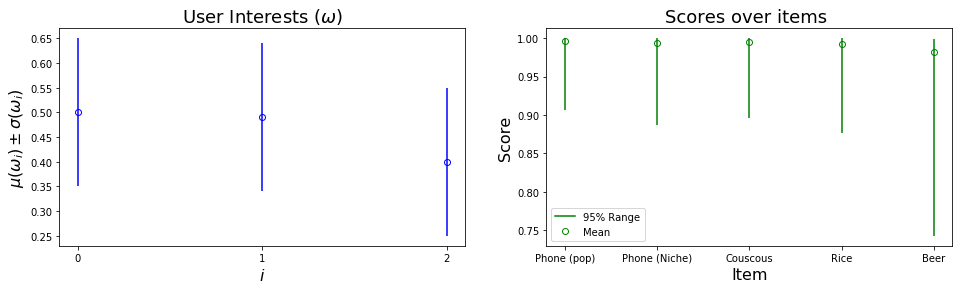

In [6]:
muq = array([.5,   # Slightly higher interest in phones
             .49,  # Slightly lower interest in grains
             .40]) # Relatively uninterested in beers
Sigmaq = diag([.15, .15 ,.15]) # Less uncertainty over phones than over other latent factors
plot_user(muq, diag(Sigmaq))

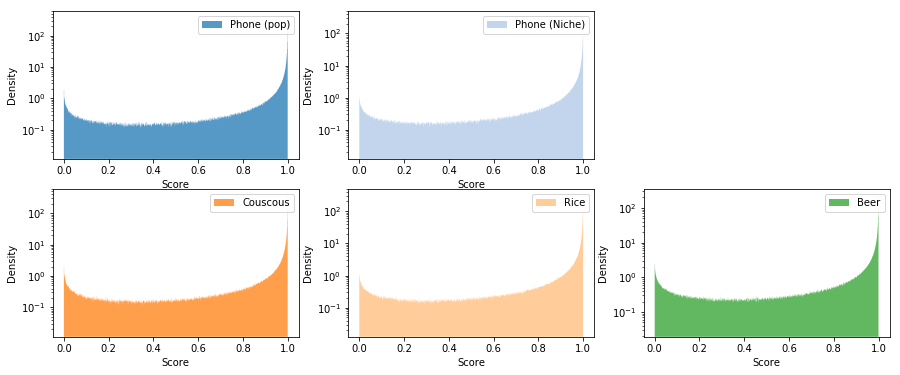

In [7]:
plot_score_distributions(muq, diag(Sigmaq))

In [8]:
ctr, probs = ctr_table(muq.reshape(K), Sigmaq)
ctr

,a1,a2,ctr (0.500),ctr (0.025),ctr (0.975)
1,Phone (pop),Couscous,0.148950,0.148898,0.149003
4,Phone (Niche),Couscous,0.148714,0.148662,0.148767
2,Phone (pop),Rice,0.148711,0.148659,0.148763
5,Phone (Niche),Rice,0.148438,0.148386,0.148490
0,Phone (pop),Phone (Niche),0.148178,0.148101,0.148255
7,Couscous,Rice,0.147424,0.147345,0.147503
3,Phone (pop),Beer,0.145000,0.144942,0.145057
6,Phone (Niche),Beer,0.144787,0.144730,0.144844
8,Couscous,Beer,0.144660,0.144602,0.144718
9,Rice,Beer,0.144405,0.144348,0.144462


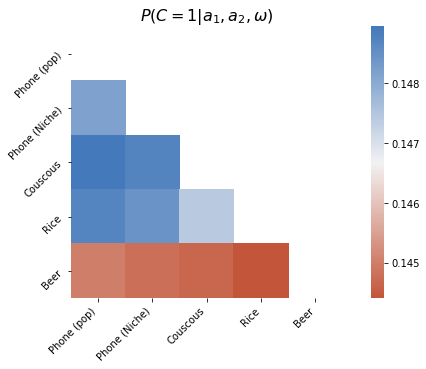

In [9]:
plot_click_probabilities(probs)

### Longer interaction history, lower uncertainty, no hedging

Imagine that this same user who has viewed some more phone pages since our last analysis.
We can update their user embedding to reflect that we now have lower uncertainty on the infered phone preferences, without significantly affecting our knowledge about their grain or beer preferences.

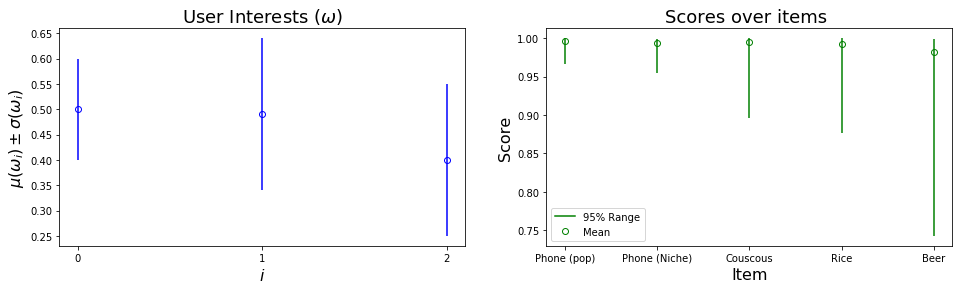

In [10]:
muq = array([.5,   # Slightly higher interest in phones
             .49,  # Slightly lower interest in grains
             .40]) # Relatively uninterested in beers
Sigmaq = diag([.1, .15 ,.15]) # Less uncertainty over phones than over other latent factors
plot_user(muq, diag(Sigmaq))

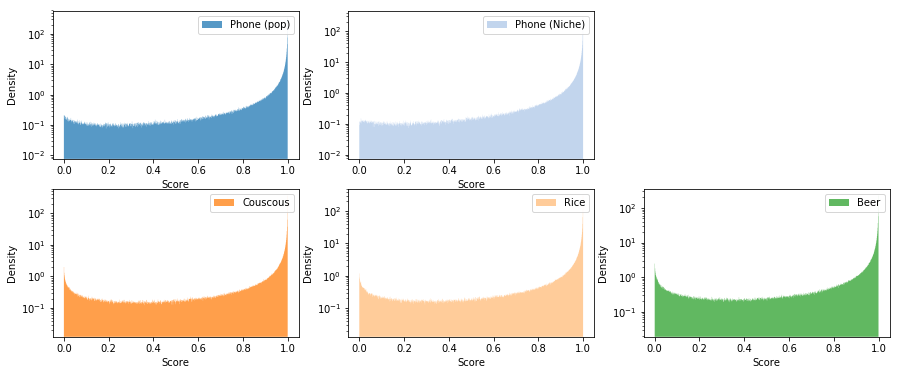

In [11]:
plot_score_distributions(muq, diag(Sigmaq))

In [12]:
ctr, probs = ctr_table(muq.reshape(K), Sigmaq)
ctr

,a1,a2,ctr (0.500),ctr (0.025),ctr (0.975)
0,Phone (pop),Phone (Niche),0.154129,0.154071,0.154188
1,Phone (pop),Couscous,0.151837,0.151790,0.151884
2,Phone (pop),Rice,0.151522,0.151475,0.151568
4,Phone (Niche),Couscous,0.151443,0.151396,0.151489
5,Phone (Niche),Rice,0.151251,0.151205,0.151297
3,Phone (pop),Beer,0.147841,0.147790,0.147893
6,Phone (Niche),Beer,0.147546,0.147494,0.147597
7,Couscous,Rice,0.147368,0.147289,0.147447
8,Couscous,Beer,0.144594,0.144537,0.144652
9,Rice,Beer,0.144331,0.144274,0.144389


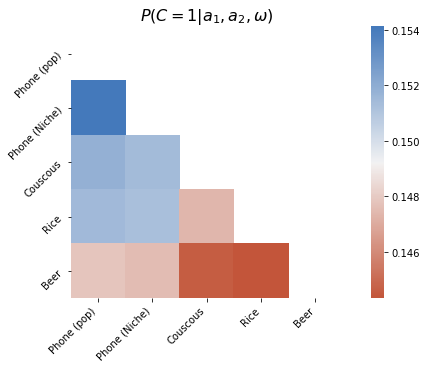

In [13]:
plot_click_probabilities(probs)

# "Real" Users: Embeddings Computed from Interaction Data

Now, let's compute the distribution from which we sample user embeddings $\omega \sim \mathcal{N}(\mu,\Sigma)$ from a user history.

As the model parameters $\Psi$ are known, we can calculate the posterior over the user embedding by optimising a lower bound with a varitional expectation-maximisation algorithm.
We will not go much deeper into this, but more information can be found in the following paper:

> Otmane Sakhi, Stephen Bonner, David Rohde, and Flavian Vasile. 2020. BLOB: A Probabilistic Model for Recommendation that Combines Organic and Bandit Signals. In Proceedings of the 26th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining (KDD '20). Association for Computing Machinery, New York, NY, USA, 783–793. DOI:https://doi.org/10.1145/3394486.3403121

In [14]:
''' Variational Bayes Expectation-Maximisation Algorithm to construct posterior over user embedding '''
def JJ(zeta):
    return 1./(2.*zeta)*(1./(1+exp(-zeta)) - 0.5)

def VBEM(v):
    xi = ones((P,1))
    a=0.3
    muq = ones((K,1))
    Sigmaq = eye(K)
    T=len(v)

    for _ in range(300):
        Sigmaq = inv(eye(K) + 2*T*array([JJ(xi[p])*matmul(Psi[p:p+1,:].T,Psi[p:p+1,:]) for p in range(P)]).sum(0))
        muq = matmul(Sigmaq,(Psi[v,:].T.sum(1,keepdims=True)-T*array([(0.5-2*a*JJ(xi[p]))*Psi[p:p+1,:].T for p in range(P)]).sum(0)))
        a=(0.5*(P/2-1)+sum([JJ(xi[p])*matmul(Psi[p:p+1,:],muq) for p in range(P)]))/sum(JJ(xi))
        for p in range(P):
            xi[p,0] = sqrt((matmul(Psi[p:p+1,:],muq)-a)**2+matmul(matmul(Psi[p:p+1,:],Sigmaq),Psi[p:p+1,:].T))
    return muq, Sigmaq, a, xi

### Short interaction history, high uncertainty and hedging
Imagine a user who has expressed a slight interest in phones and grains in the past. Our embedding will reflect this inferred interest, along with high uncertainty as it is based on just a few data points.

In [15]:
v=[rice, popular_phone]
muq, Sigmaq, a, xi = VBEM(v)

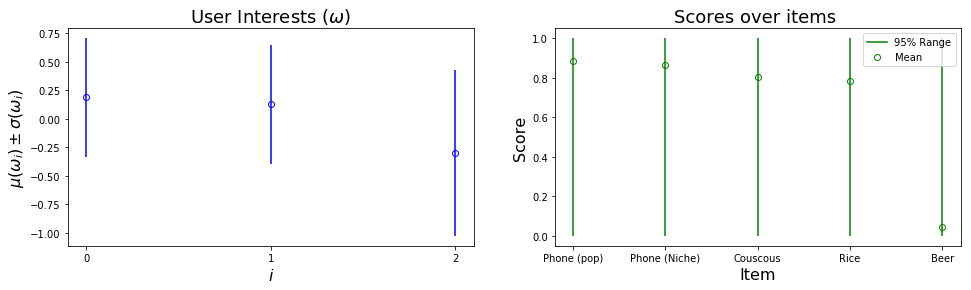

In [16]:
plot_user(muq.reshape(K), diag(Sigmaq))

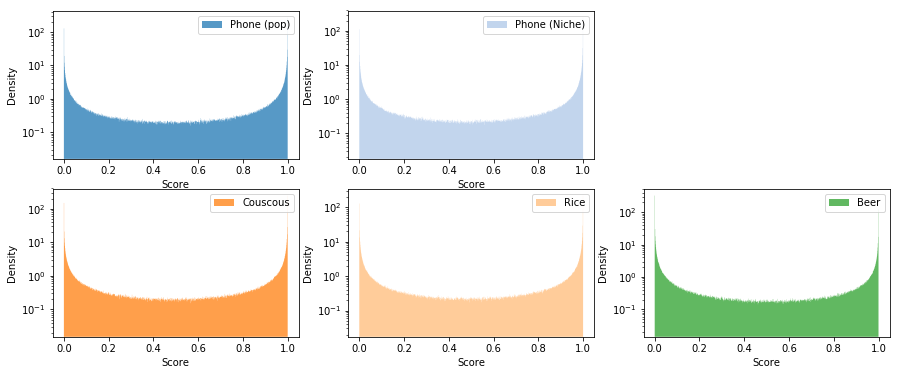

In [17]:
plot_score_distributions(muq.reshape(K), Sigmaq)

In [18]:
ctr, probs = ctr_table(muq.reshape(K), Sigmaq)
ctr

,a1,a2,ctr (0.500),ctr (0.025),ctr (0.975)
1,Phone (pop),Couscous,0.101888,0.101787,0.101988
2,Phone (pop),Rice,0.101885,0.101785,0.101985
5,Phone (Niche),Rice,0.101848,0.101749,0.101947
4,Phone (Niche),Couscous,0.101824,0.101725,0.101924
0,Phone (pop),Phone (Niche),0.101530,0.101388,0.101672
7,Couscous,Rice,0.096407,0.096264,0.096551
6,Phone (Niche),Beer,0.085135,0.085034,0.085235
3,Phone (pop),Beer,0.085127,0.085026,0.085229
9,Rice,Beer,0.082450,0.082348,0.082551
8,Couscous,Beer,0.082359,0.082257,0.082461


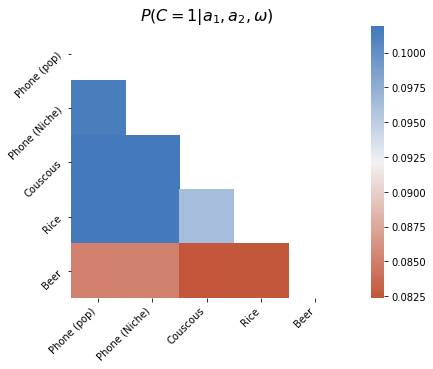

In [19]:
plot_click_probabilities(probs)

### Longer interaction history, lower uncertainty, no hedging

Imagine that this same user who has viewed some more phone pages since our last analysis.
We can update their user embedding to reflect that we now have lower uncertainty on the infered phone preferences, without significantly affecting our knowledge about their grain or beer preferences.

In [20]:
v=[rice, popular_phone,rice, popular_phone,rice, popular_phone,rice, popular_phone,rice, popular_phone,rice, popular_phone] 
muq, Sigmaq, a, xi = VBEM(v)

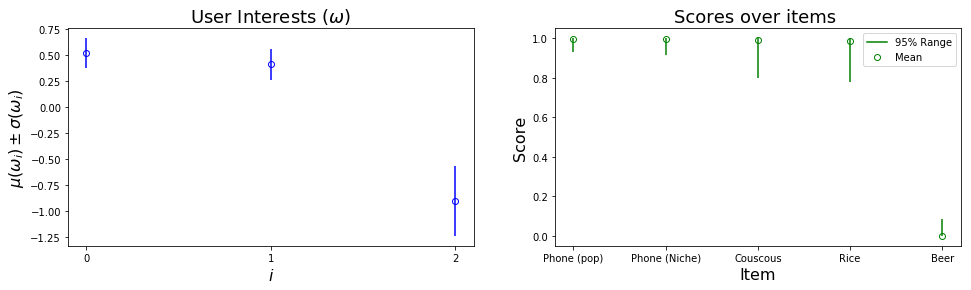

In [21]:
plot_user(muq.reshape(K), diag(Sigmaq))

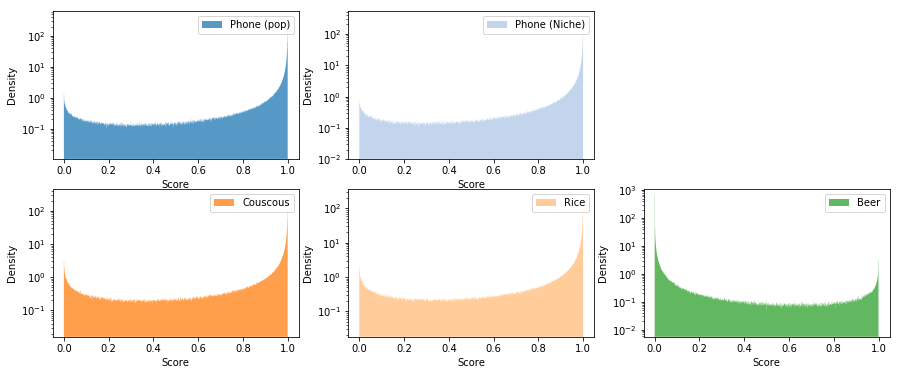

In [22]:
plot_score_distributions(muq.reshape(K), Sigmaq)

In [23]:
ctr, probs = ctr_table(muq.reshape(K), Sigmaq)
ctr

,a1,a2,ctr (0.500),ctr (0.025),ctr (0.975)
0,Phone (pop),Phone (Niche),0.150198,0.150125,0.150270
1,Phone (pop),Couscous,0.147001,0.146945,0.147056
2,Phone (pop),Rice,0.146744,0.146689,0.146799
4,Phone (Niche),Couscous,0.146707,0.146652,0.146762
5,Phone (Niche),Rice,0.146520,0.146466,0.146574
7,Couscous,Rice,0.141235,0.141145,0.141325
3,Phone (pop),Beer,0.087321,0.087269,0.087372
6,Phone (Niche),Beer,0.087017,0.086966,0.087068
8,Couscous,Beer,0.082431,0.082372,0.082490
9,Rice,Beer,0.082111,0.082053,0.082169


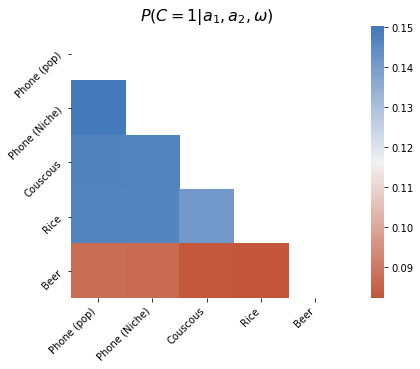

In [24]:
plot_click_probabilities(probs)